In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

W0308 00:27:41.120584 140243726948096 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/compat/v2_compat.py:63: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
tfm = tfp.models

In [3]:
# Generate synthetic data
inputs = np.arange(2,20,0.2)
outputs = 0.1*np.square(inputs) + 8*np.sin(2*inputs/3) + 0.5*np.random.randn(len(inputs))


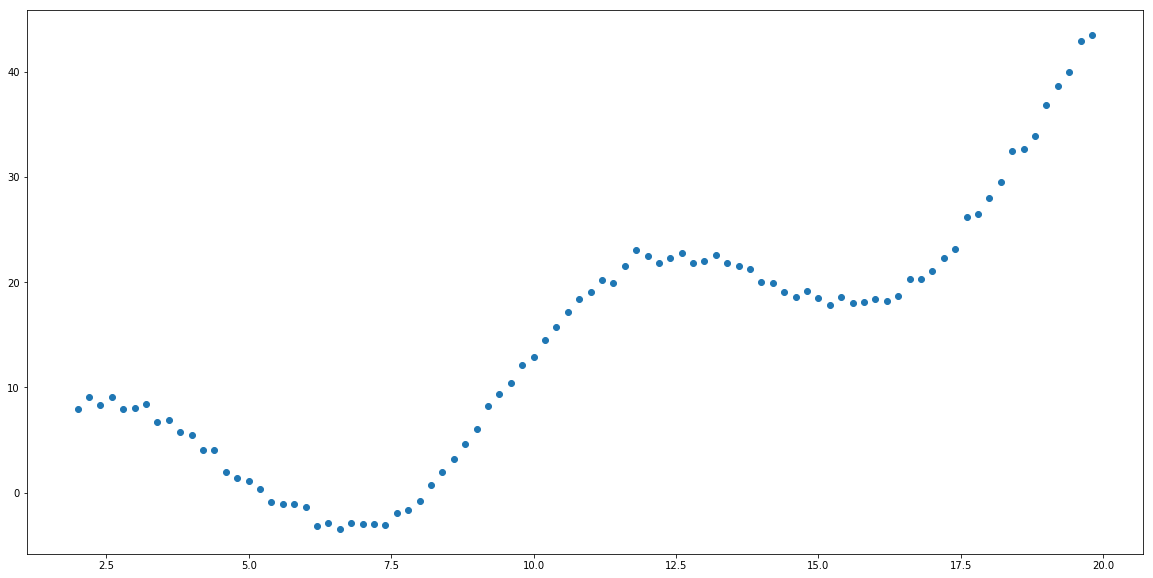

In [4]:
plt.figure(figsize =(20,10))
plt.scatter(inputs,outputs)

In [5]:
labels = ['x']

In [6]:
# Normalizing the outputs 
mean_y = np.mean(outputs)
std_y = np.std(outputs)
outputsnorm = (outputs - mean_y)/std_y

In [7]:
# normalizing the inputs
mean_x = np.mean(inputs, axis = 0)
std_x = np.std(inputs, axis = 0, keepdims = True)

inputsnorm = (inputs - mean_x)/std_x

In [8]:
model = tfm.BayesianGP(inputs= inputsnorm, outputs = outputsnorm, kernel_type = 'RBF', noise_level = 1e-3)


# HMC sampling

In [9]:
mcmc_samples = 4000
burn_in = 3000
num_leapfrog_steps = 3
num_warmup_iters = burn_in

In [10]:
# warmup phase
step_size, next_state = model.warmup(num_warmup_iters = num_warmup_iters, num_leapfrog_steps = num_leapfrog_steps)
print(step_size)

Warmup: 
Warm-Up Iteration:   0 Acceptance Rate: 1.000
Warm-Up Iteration: 500 Acceptance Rate: 0.563
Warm-Up Iteration: 1000 Acceptance Rate: 0.571
Warm-Up Iteration: 1500 Acceptance Rate: 0.563
Warm-Up Iteration: 2000 Acceptance Rate: 0.554
Warm-Up Iteration: 2500 Acceptance Rate: 0.553
Warm-Up Iteration: 2999 Acceptance Rate: 0.552
0.21113773


In [11]:
# actual sampling phase
hyperpar_samples, acceptance_rate_ = model.mcmc(mcmc_samples = mcmc_samples, num_burnin_steps =burn_in,step_size = 0.95*step_size, num_leapfrog_steps = num_leapfrog_steps, initial_state = next_state)

/root/.local/lib/python3.5/site-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "
W0308 00:27:57.709714 140243726948096 deprecation.py:323] From /root/.local/lib/python3.5/site-packages/tensorflow_probability/python/models/bayesgp/scripts/bayesiangp.py:234: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.


Acceptance rate of the HMC sampling: 0.67425


In [12]:
loc_probs_, varm_probs_, beta_probs_ = hyperpar_samples 

Text(0.5, 1.0, 'constant_mean')

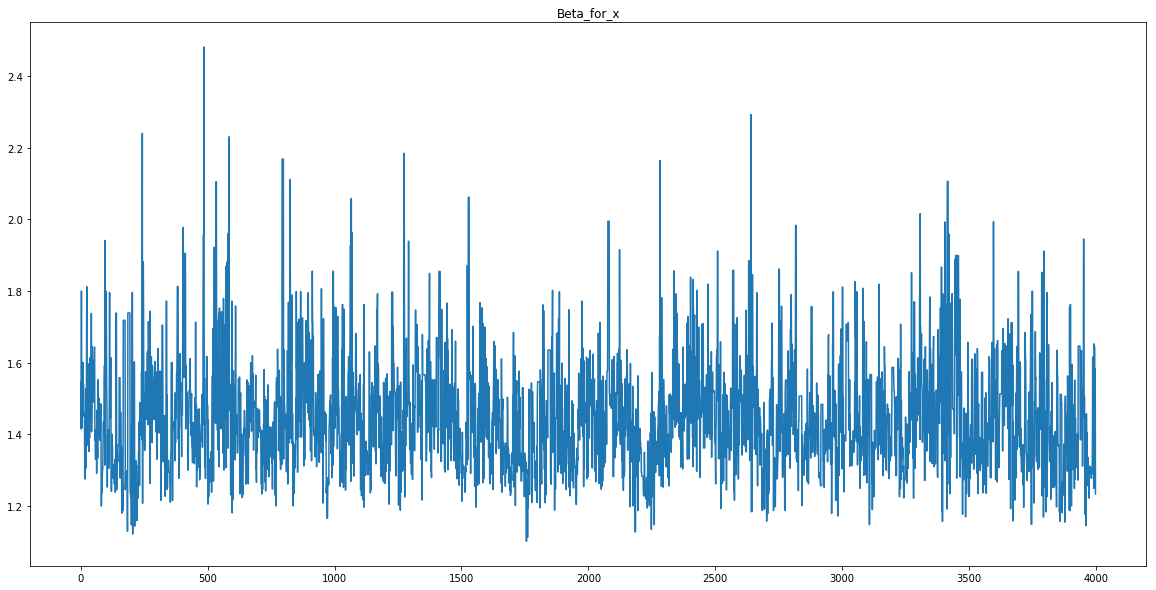

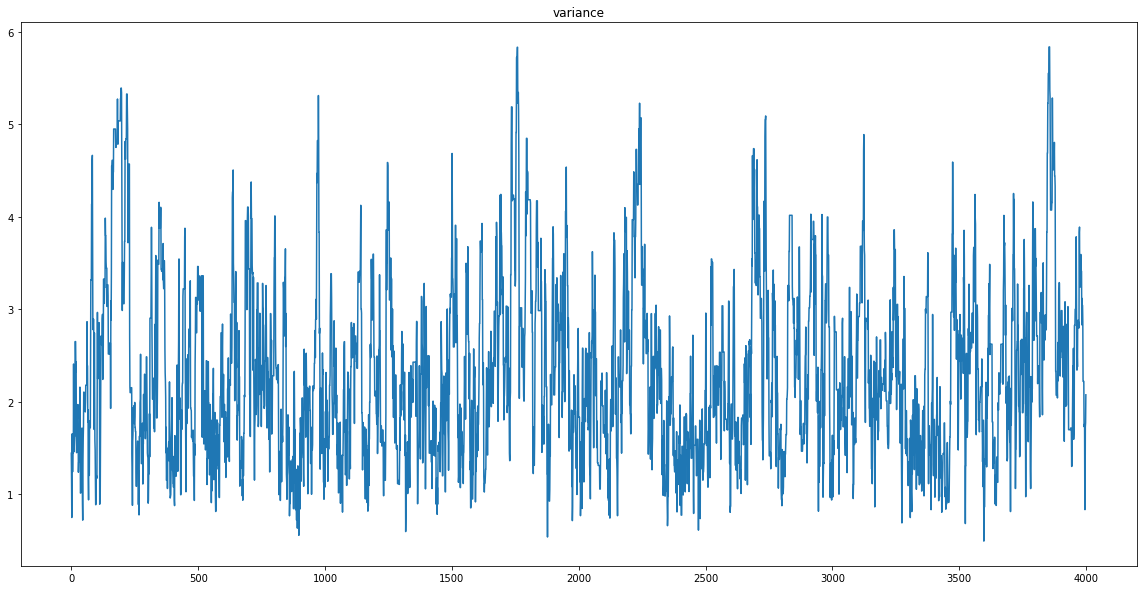

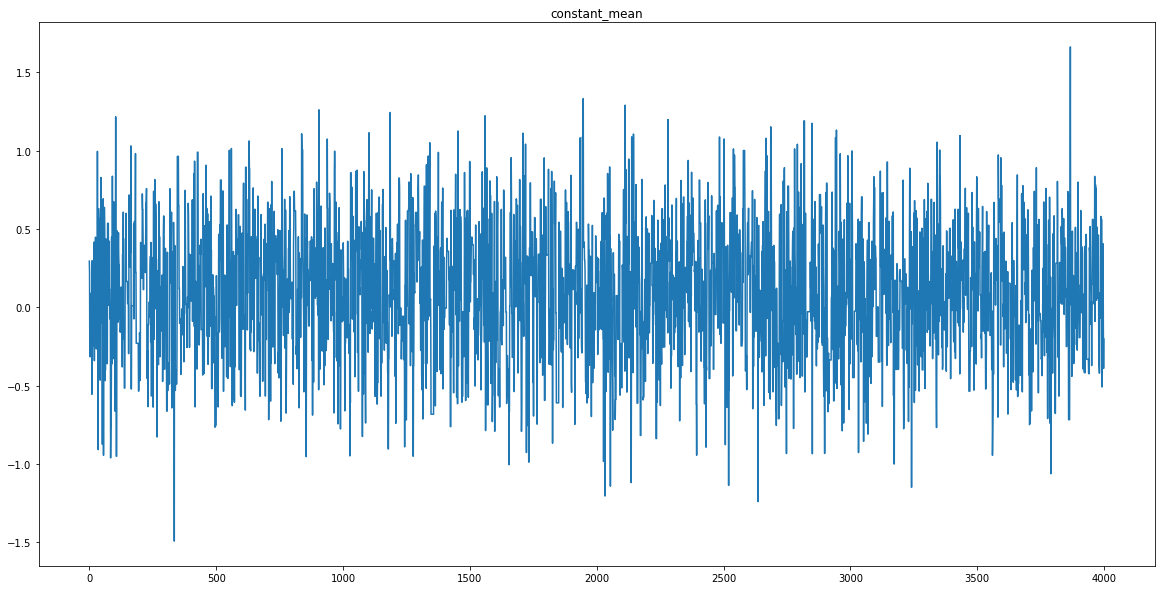

In [13]:
n_inputs = 1
# Plotting  the chains for the inverse lengthscale 
t = np.arange(mcmc_samples)
for i in range(n_inputs):
    plt.figure(figsize = (20,10))
    plt.plot(t,beta_probs_[:,i])
    title = 'Beta_for_' +  labels[i]
    plt.title(title)

    
# Plotting the chains for the variances  
plt.figure(figsize = (20,10))
plt.plot(t,varm_probs_)
title = 'variance'
plt.title(title)




# Plotting the chains for the constant mean function
plt.figure(figsize = (20,10))
plt.plot(t,loc_probs_[:])
title = 'constant_mean'
plt.title(title)


In [14]:
print(loc_probs_.shape)
print(varm_probs_.shape)
print(beta_probs_.shape)

(4000,)
(4000,)
(4000, 1)


In [15]:
#inference
# Generating posterior mean, variance of the posterior Gaussian process distribution as well as samples 
mean_pos, var_pos, samples = model.samples(inputsnorm, hyperpar_samples, num_samples = 20, with_point_samples = True)

In [16]:
print(mean_pos.shape)
print(var_pos.shape)
print(samples.shape)

(90,)
(90,)
(80000, 90)


In [17]:
std_pos = np.sqrt(var_pos)  # standard deviation values

In [18]:
# Converting to the right scale
mean_posf = mean_pos*std_y + mean_y 
std_posf = std_pos*std_y 
samplesf = samples*std_y + mean_y

In [19]:
lower = np.percentile(samplesf,2.5, axis = 0)
upper = np.percentile(samplesf,97.5, axis = 0)

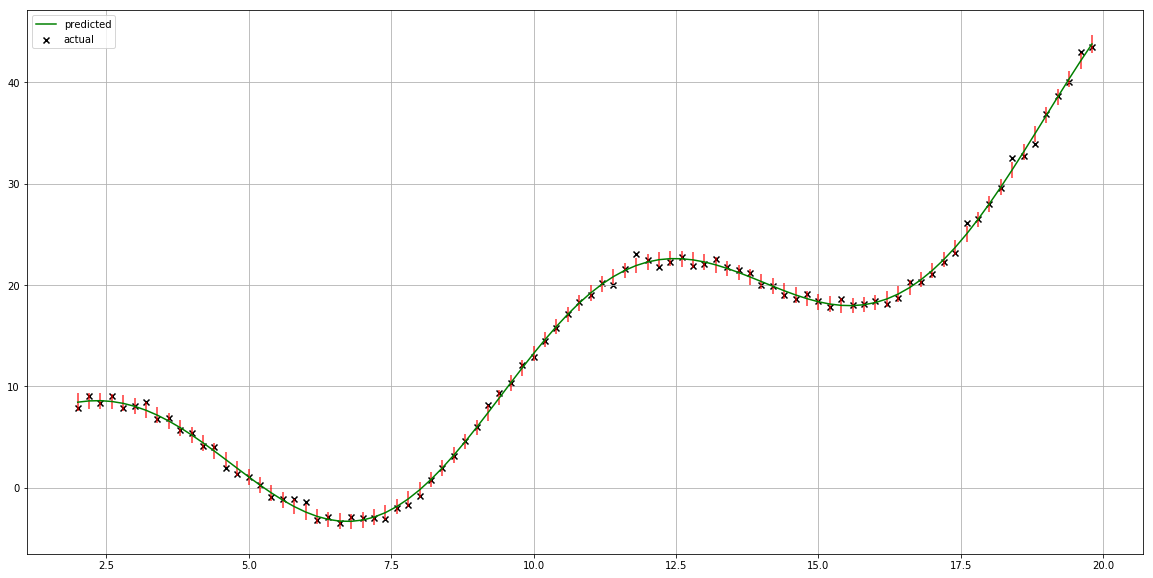

In [20]:
plt.figure(figsize =(20,10))
plt.scatter(inputs,outputs,marker='x', color = 'black', label = 'actual')
plt.plot(inputs, mean_posf, color = 'green', label = 'predicted')
plt.vlines(inputs, lower, upper, color = 'red', alpha = 0.8)
plt.grid()
plt.legend()

   